# Convolutional Neural Networks -  Duck or Rabbit? 
### *by Bartłomiej Wójcik* 

This project focuses on building, training and implementing a CNN-based classifier that is able to discriminate and distinguish between ducks and rabbits. Implementation is accompanied by an analysis of obatained results and embeddings visualisation. Additionally, an attempt of transfer learning has been carried out for the cats and dogs classification problem. Finally, a functionality that enables real-time ducks and rabbits recognition was implemented.  <br><br>
<font size="3">The project consists of following parts:  

* Motivation
* Libraries and tools
* Scraping data from Google Images 
* Preparing data and creating generators 
* Building and training the CNN model
* Results analysis 
* PCA visualisation of embeddings 
* Transfer learning - cats and dogs
* Real-time recogniton of Ducks&Rabbits 
* Summary
* Literature references</font>

# 1. Motivation

Chances are you have already come across one of these optical illusions shown below. Probably after a short while, you started to realize that each pictutre may depict either a rabbit or a duck and maybe you colud even switch between these two effortlessly. This phenomenonon occurs due to how our brain processes visual information. Human visual system creates representation of objects based on certain features, so if it sees features of two different animals it has a hard time deciding which one actually is in the photograph. Roughly the same process happens in convolutional networks. CNN filters detect specific patterns in a given input image and create an abstract representation of the photo (feature vector) which is used to predict the object category (in the case of discriminative networks).

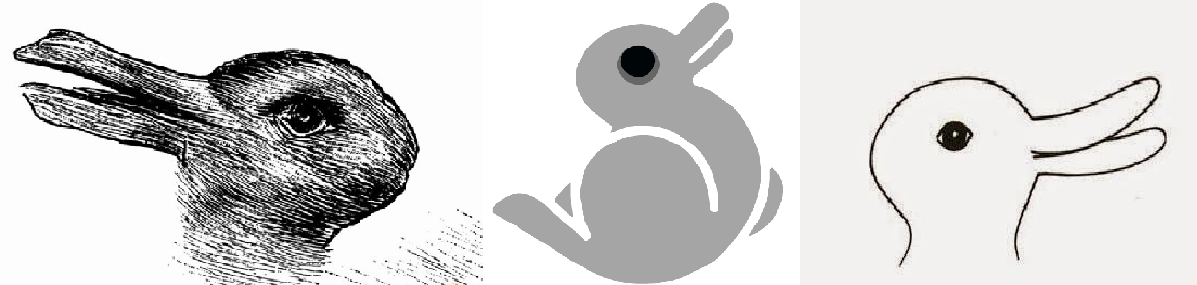

In [2]:
display(Img(filename='rabbit_or_duck.png', width=1000))

<font size = '3'>The motivation behind the project was to train a ConvNet model and let AI make a final decision whether it is a rabbit or a duck ;)</font>

# 2. Libraries and tools

In [2]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense 
from keras import backend as K 
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import cv2
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from platform import python_version
from IPython.display import Image as Img
from PIL import Image
from bs4 import BeautifulSoup
import requests
import random
import time
from selenium import webdriver
import io
import requests
import os
import re
from skimage.io import imread
from skimage import transform
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

Using TensorFlow backend.


In [3]:
# printing out versions of crucial libraries 
print("Python version: " + python_version() + 
      "\nTensorflow version: " + tf.__version__ + 
      "\nKeras version: " + keras.__version__ +
      "\nOpenCV version: " + cv2.__version__ )

Python version: 3.7.7
Tensorflow version: 2.1.0
Keras version: 2.3.1
OpenCV version: 4.2.0


# 3. Scraping data from Google Images

The scrapper is modified and updated version of a scrapper from [this](https://towardsdatascience.com/image-scraping-with-python-a96feda8af2d) post. Functions has been unified and CSS selctors has been updated. It is good to keep in mind that webpages keep changing so the scraper might not be valid again after some time.

In [11]:
# google images scrapper function
def download_images(query, images_number):
        
    # load selenium webdriver
    wd = webdriver.Chrome(executable_path='driver/chromedriver.exe')
    
    # download path
    folder_path = 'images\{}\\'.format(query)
    
    # create if doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # time between interactions (so it seems as if a real person uses a browser)
    waiting_time = 0.3
    
    # webpage url
    crawl_url = "https://www.google.com/search?tbm=isch&source=hp&q={a}&oq={b}&gs_l=img".format(a=query,b=query)
    
    # open webpage in a browser
    wd.get(crawl_url)
    
    # initialize set for urls (set prevents duplicates)
    image_urls = set()
    
    # found images counter 
    image_counter = 0
    # start
    results_start = 0
        
    # loop switch (active if there is more pictures available on the webpage)
    there_is_more=True
    
    # execute when there is more pictures available and the image counter is below the number specified in function
    while image_counter < images_number and there_is_more==True:
        
        # execute JS command - scroll down
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(waiting_time)
        
        # detects thumbnails
        thumbnails = wd.find_elements_by_css_selector('.tx8vtf')
        # number of thumbnails detected
        results_last = len(thumbnails)
        
        # for each thumbnail detected [from first to last] try to click on the link provided by 'src' tag
        for img in thumbnails[results_start:results_last]: 
            if img.get_attribute('src'):                
                try:
                    img.click()
                    time.sleep(waiting_time)
                except:
                    pass
                
                # extract image urls
                images = wd.find_elements_by_css_selector('.tx8vtf')
                for image in images:
                    if image.get_attribute('src'):
                        image_urls.add(image.get_attribute('src'))
                        
                # update image counter so it is equal to number of urls collected
                image_counter = len(image_urls)
                # update results_start variable so the next iteration starts from where the prvious one was finished
                results_start = results_last
                # update results_last
                results_last = len(thumbnails)                
                
                # break the loop when we have more links than desired number declared in the function
                if len(image_urls) >= images_number:
                    print("Found {} links".format(str(image_counter)))
                    break
        
        # look for more images if load button available 
        else:
            print("Found {} links".format(str(image_counter)))
            time.sleep(waiting_time)
            more_results = wd.find_element_by_css_selector(".mye4qd")
            
            # load more
            if more_results: #and results_last>results_start:
                wd.execute_script("document.querySelector('.mye4qd').click();")
                
                # update result_start
                results_start = results_last
                print('Continue scraping...')
            else:
                there_is_more=False
         


    # download images from urls list       
    for url in image_urls:
        try:
            image_content = requests.get(url).content
        except:
            pass
        
        
        # download path with filename (random number)
        file_path = os.path.join(folder_path, str(random.randint(10000000,99999999)) + '.jpg')
        
        # save image in the specified folder
        with open(file_path, 'wb') as f:
            f.write(image_content)

    
    print("Downloading completed, {} images saved".format(str(len(image_urls))))

In [12]:
download_images('kaczka', 1500)

Found 1387 links
Continue scraping...
Found 1500 links


# 4. Preparing data and creating generators
After scrapping, images has been manually cleaned and divided into three sets.

In [68]:
# subfolders with data
train_dir= 'ducks_and_rabbits/train'
validation_dir = 'ducks_and_rabbits/validation'
test_dir = 'ducks_and_rabbits/test'
# number of samples
train_count = 2800
validation_count = 800
test_count = 400
# epochs and batch size
epochs = 50
batch_size = 100
# input shape
img_width, img_height = 228, 228
input_shape = (img_width, img_height, 1) # configuration 'channels_last'

In [5]:
# generate distortions
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=(0.88,1.12),
    shear_range=0.12,
    zoom_range=0.12,
    rotation_range=15,
    width_shift_range=0.12,
    height_shift_range=0.12,
    horizontal_flip=True)
# validation and test are only scaled (pixel values normalized - between 0 and 1) 
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# train generator - augmentation 'on the fly'
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True)
# validation generator 
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True)
# test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False)

Found 2800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


# 5. Building and training CNN model

Model was trained on NVIDIA GTX1050. CUDA and special versions of Keras and Tensorflow libraries (supporting GPU) has been used. <br>
Standard and simple architecture: each Convolutional layer followed by ReLU activation, MaxPooling and BatchNormalization to stabilize training process. <br>
Increasing number of filters - 32->64->128->128->128 with filter size of 5x5 (except 3x3 at the first layer to detect simple edges)

In [8]:
# adam as optimizer - smaller learning rate (than default) will help with more stable training process (prevents overshooting)
adam = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [69]:
# building Convolutiona Neural Network by adding subsequent layers
model = Sequential()

# 1st layer - convolutional
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(momentum=0.9))

# 2nd layer - convolutional
model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(momentum=0.9))

# 3rd layer - convolutional
model.add(Conv2D(128, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(momentum=0.9))

# 4th layer - convolutional
model.add(Conv2D(128, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(momentum=0.9))

# 5th layer - convolutional
model.add(Conv2D(128, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(momentum=0.9))

# flatten
model.add(Flatten())
# apply dropout - randomly turn off 50% of neurons for a batch
model.add(Dropout(0.5))

# 6th layer - fully connected
model.add(Dense(128))
model.add(Activation('relu'))

# 7th layer - sigmoid activation
model.add(Dense(1))
model.add(Activation('sigmoid'))

# compile model 
# specify loss function, optimizer and metric
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [70]:
# creating callback - save best model based on validation accuracy
best_model_path = 'model_best.h5'
saving_best_model = ModelCheckpoint(best_model_path, monitor='val_accuracy', save_best_only=True)

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 226, 226, 32)      320       
_________________________________________________________________
activation_8 (Activation)    (None, 226, 226, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 113, 113, 32)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 113, 113, 32)      128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 64)      51264     
_________________________________________________________________
activation_9 (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 64)       

In [71]:
# model training
# variable 'training' stores dictionary with a history of learning process
training = model.fit_generator(
                generator=train_generator,
                steps_per_epoch=train_count // batch_size,
                epochs=epochs,
                callbacks=[saving_best_model],
                validation_data=validation_generator,
                validation_steps=validation_count // batch_size)

Epoch 1/50
28/28 [==============================] - 22s 777ms/step - loss: 0.8118 - accuracy: 0.6479 - val_loss: 1.1410 - val_accuracy: 0.4913
Epoch 2/50
28/28 [==============================] - 20s 710ms/step - loss: 0.6473 - accuracy: 0.6968 - val_loss: 0.5709 - val_accuracy: 0.7038
Epoch 3/50
28/28 [==============================] - 20s 712ms/step - loss: 0.5708 - accuracy: 0.7371 - val_loss: 0.3818 - val_accuracy: 0.7950
Epoch 4/50
28/28 [==============================] - 20s 712ms/step - loss: 0.5117 - accuracy: 0.7639 - val_loss: 0.3697 - val_accuracy: 0.8112
Epoch 5/50
28/28 [==============================] - 20s 712ms/step - loss: 0.4898 - accuracy: 0.7718 - val_loss: 0.5189 - val_accuracy: 0.7113
Epoch 6/50
28/28 [==============================] - 20s 713ms/step - loss: 0.4883 - accuracy: 0.7832 - val_loss: 0.5031 - val_accuracy: 0.8025
Epoch 7/50
28/28 [==============================] - 20s 714ms/step - loss: 0.4686 - accuracy: 0.7889 - val_loss: 0.3207 - val_accuracy: 0.8075

In [72]:
# save history in json file
with open('history.txt', 'w') as json_file:
    json.dump(str(training.history), json_file)

# 6. Results analysis

In [73]:
# calculate accuracy for test data
test_generator.reset()
_, accuracy = model.evaluate_generator(generator=test_generator, steps=len(test_generator))
print("Test accuracy: " + str(np.round(accuracy,4)))

Test accuracy: 0.8725


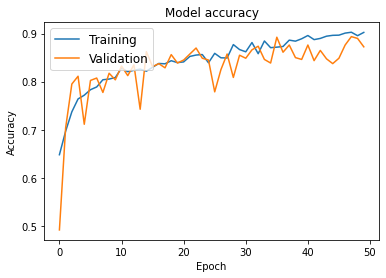

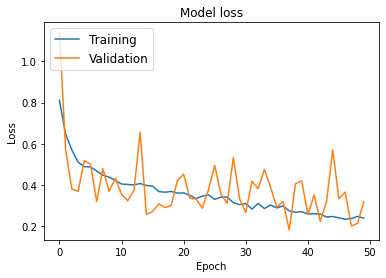

In [74]:
# accuracy for training and validation set
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
#loss for training and validation set
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

Test accuracy amounts to 87.25% which is quite moderate result in binary classification. It is clear that the training process could bo more stable. Hyperparameters tuning and experimenting with architecture configuration could help (along with larger training set).

In [75]:
# predict values for test set
test_generator.reset()
y_pred=model.predict_generator(test_generator, steps=len(test_generator))

In [76]:
# create categories using 0.5 threshold (1 for Rabbit and 0 for Duck)
predicted_classes = []
for i in range(len(list(y_pred))):
    predicted_class_indices=0 if y_pred[i]<0.50 else 1
    predicted_classes.append(predicted_class_indices)

In [77]:
# rounded y_pred
y_pred_rounded = np.round(y_pred,3)
y_pred_rounded[:10]

array([[0.011],
       [0.018],
       [0.072],
       [0.905],
       [0.001],
       [0.459],
       [0.024],
       [0.212],
       [0.004],
       [0.198]], dtype=float32)

In [78]:
# labels stores dictionary with categories (key - number, value - animal)
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
# list with test data predictions
predictions = [labels[k] for k in predicted_classes]
# list with values of test data predictions
prediction_values = [(y_pred_rounded[i]) for i in range(len(y_pred_rounded))]
# list with folder name (animal) and photo name
filenames = test_generator.filenames

In [79]:
labels

{0: 'DUCK', 1: 'RABBIT'}

In [80]:
predictions[:10]

['DUCK',
 'DUCK',
 'DUCK',
 'RABBIT',
 'DUCK',
 'DUCK',
 'DUCK',
 'DUCK',
 'DUCK',
 'DUCK']

In [81]:
prediction_values[:10]

[array([0.011], dtype=float32),
 array([0.018], dtype=float32),
 array([0.072], dtype=float32),
 array([0.905], dtype=float32),
 array([0.001], dtype=float32),
 array([0.459], dtype=float32),
 array([0.024], dtype=float32),
 array([0.212], dtype=float32),
 array([0.004], dtype=float32),
 array([0.198], dtype=float32)]

In [82]:
filenames[:10]

['DUCK\\36970525.jpg',
 'DUCK\\37042178.jpg',
 'DUCK\\37092469.jpg',
 'DUCK\\37108480.jpg',
 'DUCK\\37161589.jpg',
 'DUCK\\37228849.jpg',
 'DUCK\\37313024.jpg',
 'DUCK\\37365913.jpg',
 'DUCK\\37374072.jpg',
 'DUCK\\37577655.jpg']

In [83]:
# lists with animals and photos (take label (folder name) and separate from the filename)
animals = []
photos = []
for i in filenames:
    animal,photo = i.split('\\')
    animals.append(animal)
    photos.append(photo)

In [84]:
# DataFrame z categories predicted and values
results=pd.DataFrame({"Animal": animals,
                      "Photo": photos,
                      "Prediction": predictions,
                      "Value": prediction_values})

In [85]:
# reset index
results = results.reset_index(drop=True)

In [86]:
# funtion transforms sigmoid values into probabilities (in %)
# if predicted value is less than threshold we need to subtract that value from 1 
# ^^ (because model predicted reference category so we need to 'flip' the value)
def adjust_values(df):
    if df['Value'] < 0.5:
        return np.round(100*(1 - df['Value']),4) 
    else:
        return np.round(100*df['Value'],4)

In [87]:
# add column with percentages and grop column with sigmoid values
results['Percentages'] = results.apply(adjust_values, axis=1)
results = results.drop(columns=['Value'])
results.to_excel('results.xls')

In [88]:
# preveiw
results

,Animal,Photo,Prediction,Percentages
0,DUCK,36970525.jpg,DUCK,[98.9]
1,DUCK,37042178.jpg,DUCK,[98.2]
2,DUCK,37092469.jpg,DUCK,[92.8]
3,DUCK,37108480.jpg,RABBIT,[90.5]
4,DUCK,37161589.jpg,DUCK,[99.9]
...,...,...,...,...
395,RABBIT,32796075.jpg,DUCK,[82.3]
396,RABBIT,32952388.jpg,RABBIT,[98.1]
397,RABBIT,33466285.jpg,RABBIT,[95.1]
398,RABBIT,33742263.jpg,RABBIT,[90.5]


In [89]:
# crate contingency table 
results_TP = results.groupby(["Animal", "Prediction"]).count()
results_TP = results_TP.drop(columns=['Percentages'])
results_TP = results_TP.rename(columns={"Photo": "Recognized"})
results_TP

Recognized
Animal Prediction            
DUCK   DUCK               185
       RABBIT              15
RABBIT DUCK                36
       RABBIT             164

# 7. Visualisation of embeddings using PCA

In [90]:
# load model
model = keras.models.load_model('model_best.h5')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 226, 226, 32)      320       
_________________________________________________________________
activation_29 (Activation)   (None, 226, 226, 32)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 113, 113, 32)      0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 113, 113, 32)      128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 109, 109, 64)      51264     
_________________________________________________________________
activation_30 (Activation)   (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 54, 54, 64)       

### Trimming model so it outputs feature vectors

In [91]:
# output of new model model is flatten layer - vector representation of an image
layer_output=model.get_layer('flatten_5').output
intermediate_model=Model(inputs=model.input,outputs=layer_output)
intermediate_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21_input (InputLayer) (None, 228, 228, 1)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 226, 226, 32)      320       
_________________________________________________________________
activation_29 (Activation)   (None, 226, 226, 32)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 113, 113, 32)      0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 113, 113, 32)      128       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 109, 109, 64)      51264     
_________________________________________________________________
activation_30 (Activation)   (None, 109, 109, 64)      0   

### Sample 100 images from test set

In [92]:
duck_test_dir = 'ducks_and_rabbits/test/DUCK'
rabbit_test_dir = 'ducks_and_rabbits/test/RABBIT'

ducks_test=[]

for file in os.listdir(duck_test_dir):
        try:
            img = imread(os.path.join(duck_test_dir+'//'+file), as_gray=True)
            img = transform.resize(img,(228, 228))
            img = img.reshape(img.shape + (1,))

            ducks_test.append(("DUCK",img))
        except:
            pass
        

rabbits_test=[]

for file in os.listdir(rabbit_test_dir):
        try:
            img = imread(os.path.join(rabbit_test_dir+'//'+file), as_gray=True)
            img = transform.resize(img,(228, 228))
            img = img.reshape(img.shape + (1,))

            rabbits_test.append(("RABBIT",img))
        except:
            pass

In [93]:
print(len(ducks_test))
print(len(rabbits_test))

196
199


In [94]:
# take 50 samples per category
ducks_test = ducks_test[:50]
rabbits_test = rabbits_test[:50]
total_test = ducks_test+rabbits_test

In [95]:
df_test = pd.DataFrame(total_test, columns=["animal", "image"])
len(df_test)

100

In [96]:
df_test.head()

,animal,image
0,DUCK,"[[[0.6062074548447036], [0.6028651764570094], ..."
1,DUCK,"[[[0.1390521224630207], [0.12776979618163117],..."
2,DUCK,"[[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1..."
3,DUCK,"[[[0.17495254901960783], [0.17495254901960783]..."
4,DUCK,"[[[0.0984296353327412], [0.12104395218890752],..."


### Ducks

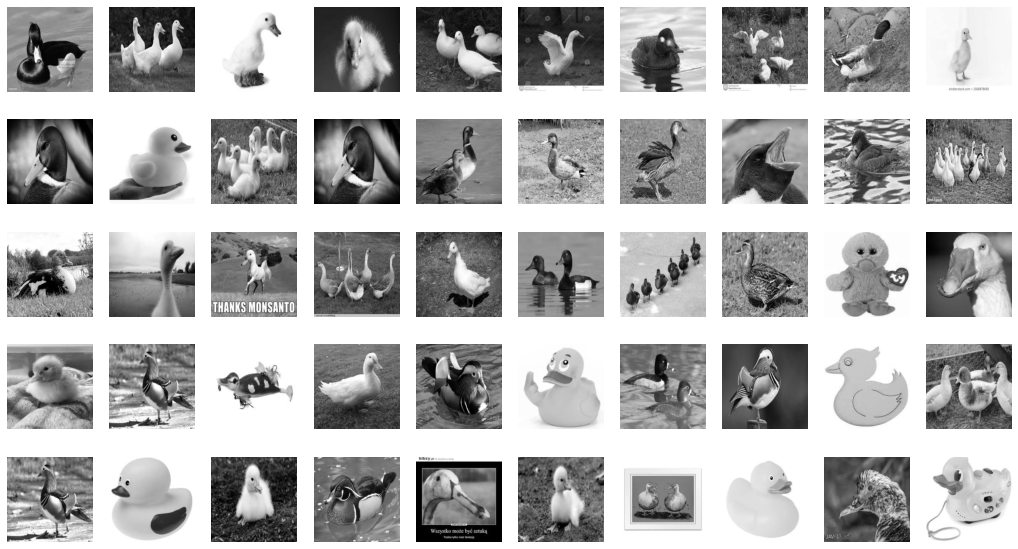

In [97]:
fig=plt.figure(figsize=(18, 10))
columns = 10
rows = 5
for i in range(1, columns*rows +1):
    img = total_test[i-1][1]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    fig.subplots_adjust()
    plt.imshow(np.squeeze(img,axis=2), cmap='gray')
plt.show()

### Rabbits

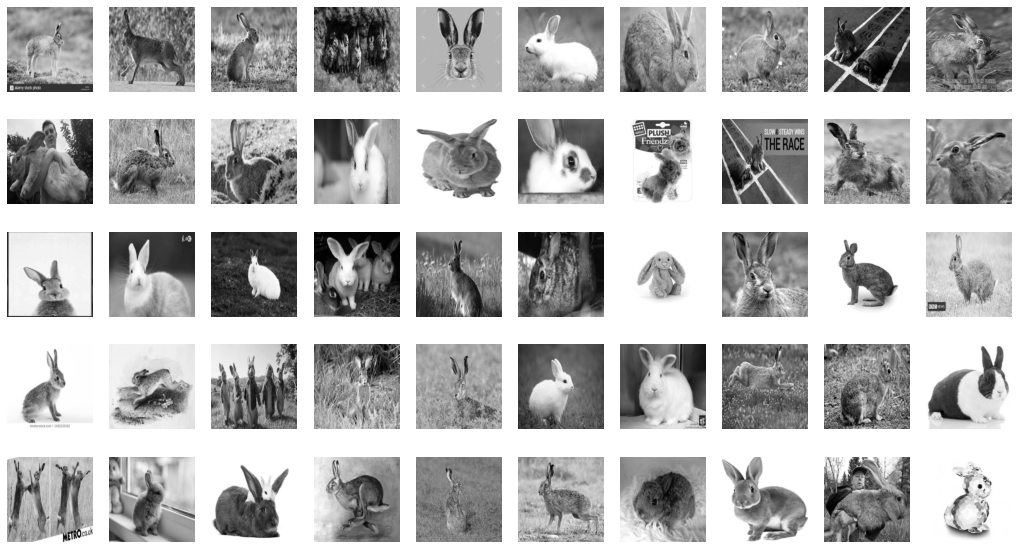

In [98]:
fig=plt.figure(figsize=(18, 10))
columns = 10
rows = 5
for i in range(1, columns*rows +1):
    img = total_test[i+49][1]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    fig.subplots_adjust()
    plt.imshow(np.squeeze(img,axis=2), cmap='gray')
plt.show()

### Coding images (x) and labels (y)

In [99]:
# labels array 
y_duck = [0 for i in range(50)]
y_rabbit = [1 for i in range(50)]
y_total = y_duck + y_rabbit
y_total = np.array(y_total)

In [100]:
# prepare tensor
x_total = np.array(list(df_test.image.values))
print(x_total.shape)

(100, 228, 228, 1)


### Creating embeddings - Ducks and Rabbits

In [101]:
x_total_embeddings = intermediate_model.predict(x_total)
x_total_embeddings.shape

(100, 1152)

### PCA
3D embeddings visualisation with PCA dimensionality reduction

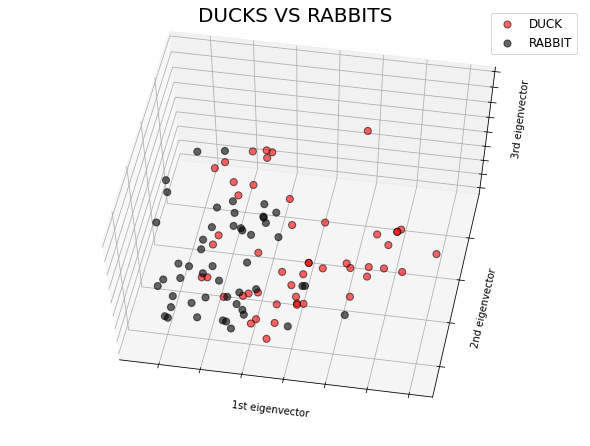

In [114]:
x_pca = x_total_embeddings
y_pca = y_total


X_transformed = PCA(n_components=3).fit_transform(x_pca)


x1 = X_transformed[:50]
x2 = X_transformed[50:100]


fig = plt.figure(figsize=(8,6))

ax = Axes3D(fig, elev=60, azim=-80)
plt.rcParams['legend.fontsize'] = 12   
ax.scatter(x1[:,0], x1[:,1], x1[:,2], color= 'red', label='DUCK', s=50, alpha=0.6, edgecolor='k')
ax.scatter(x2[:,0], x2[:,1], x2[:,2], color= 'black', label='RABBIT', s=50, alpha=0.6, edgecolor='k')

ax.set_title("DUCKS VS RABBITS", fontsize=20, pad=20)
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels(ticklabels="")
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels(ticklabels="")
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels(ticklabels="")


ax.legend(loc='upper right')

plt.show()

Clusters are not clearly separated although it we can observe some separation in low-dimensional space.

# 8. Transfer learning - cats and dogs
This is to check whether a model trained on ducks and rabbits can use its knowledge to create effective embeddings

In [115]:
cat_test_dir = 'dogs_vs_cats/CAT'
dog_test_dir = 'dogs_vs_cats/DOG'

cats_test=[]

for file in os.listdir(cat_test_dir):
        try:
            img = imread(os.path.join(cat_test_dir+'//'+file), as_gray=True)
            img = transform.resize(img,(228, 228))
            img = img.reshape(img.shape + (1,))

            cats_test.append(("CAT",img))
        except:
            pass
        

dogs_test=[]

for file in os.listdir(dog_test_dir ):
        try:
            img = imread(os.path.join(dog_test_dir+'//'+file), as_gray=True)
            img = transform.resize(img,(228, 228))
            img = img.reshape(img.shape + (1,))

            dogs_test.append(("DOG",img))
        except:
            pass

In [116]:
total_transfer = cats_test+dogs_test
print(len(cats_test))
print(len(dogs_test))
print(len(total_transfer))

50
50
100


In [117]:
df_transfer = pd.DataFrame(total_transfer, columns=["animal", "image"])
len(df_transfer)

100

### Cats

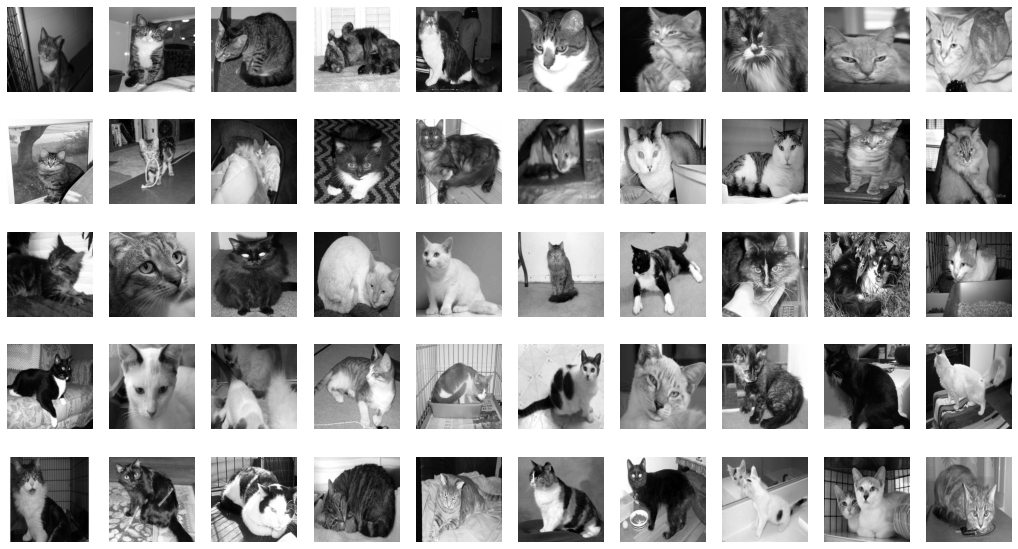

In [118]:
fig=plt.figure(figsize=(18, 10))
columns = 10
rows = 5
for i in range(1, columns*rows +1):
    img = total_transfer[i-1][1]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    fig.subplots_adjust()
    plt.imshow(np.squeeze(img,axis=2), cmap='gray')
plt.show()

### Dogs

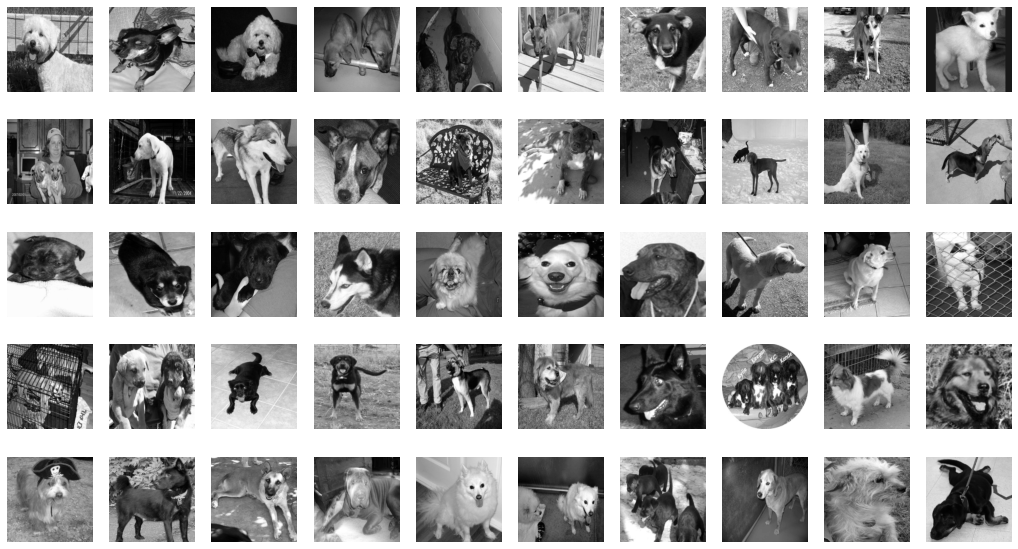

In [119]:
fig=plt.figure(figsize=(18, 10))
columns = 10
rows = 5
for i in range(1, columns*rows +1):
    img = total_transfer[i+49][1]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    fig.subplots_adjust()
    plt.imshow(np.squeeze(img,axis=2), cmap='gray')
plt.show()

### Creating images (x), (y) remains the same

In [120]:
x_transfer = np.array(list(df_transfer.image.values))
print(x_transfer.shape)

(100, 228, 228, 1)


### Creating embeddings - Cats and Dogs

In [121]:
x_transfer_embeddings = intermediate_model.predict(x_transfer)
x_transfer_embeddings.shape

(100, 1152)

### PCA

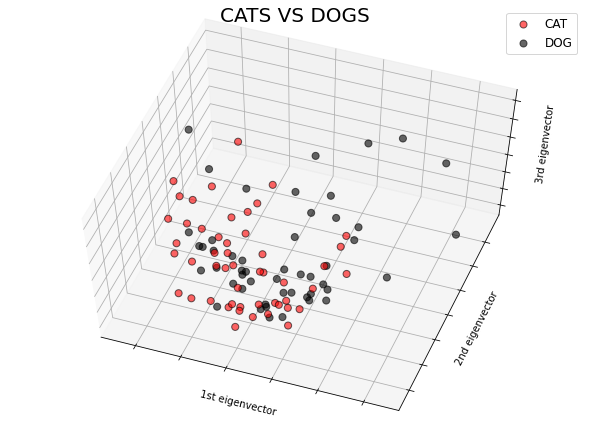

In [125]:
x_pca = x_transfer_embeddings
y_pca = y_total


X_transformed = PCA(n_components=3).fit_transform(x_pca)


x1 = X_transformed[:50]
x2 = X_transformed[50:100]


fig = plt.figure(figsize=(8,6))

ax = Axes3D(fig, elev=60, azim=-70)
plt.rcParams['legend.fontsize'] = 12   
ax.scatter(x1[:,0], x1[:,1], x1[:,2], color= 'red', label='CAT', s=50, alpha=0.6, edgecolor='k')
ax.scatter(x2[:,0], x2[:,1], x2[:,2], color= 'black', label='DOG', s=50, alpha=0.6, edgecolor='k')

ax.set_title("CATS VS DOGS", fontsize=20, pad=20)
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels(ticklabels="")
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels(ticklabels="")
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels(ticklabels="")


ax.legend(loc='upper right')

plt.show()

Embeddings are not separated, transfer learning probably would not be possible in that case

# 9. Real-time recognition of Ducks&Rabbits

In [126]:
def predict(file):
    
    # read image in grayscale
    image = cv2.imread(file,0)
    adjusted_size = cv2.resize(image, (228,228))
    
    #adjust shape to network's input shape
    adjusted_scale = img_to_array(adjusted_size/255)  
    adjusted_shape = adjusted_scale.reshape((1,) + adjusted_scale.shape)  # shape (1, 228, 228, 1)

    # prediction for inpute image and comment depending on predicted category
    pred = model.predict(adjusted_shape)
    if pred > 0.9:
        rabbit_probability = np.round(100*pred[0][0],2)
        a = Img(filename=file,width=300)
        display(a)
        print("Well... this animal looks like a rabbit, I'd say for {}% ^^".format(rabbit_probability))
    
    elif pred < 0.1:
        duck_probability = np.round(100*(1 - pred[0][0]),2) 
        a = Img(filename=file,width=300)
        display(a)
        print("Well... this animal looks like a duck, I'd say for {}% ^^".format(duck_probability))
    
    else:
        a = Img(filename=file,width=300)
        display(a)
        print("Sorry, I don't know what's in the photo :(")

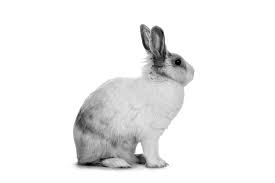

Well... this animal looks like a rabbit, I'd say for 94.73% ^^


In [138]:
predict('rab.jpg')

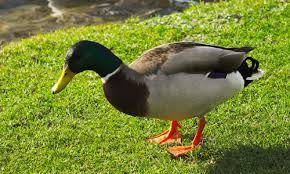

Well... this animal looks like a duck, I'd say for 99.5% ^^


In [140]:
predict('ducc.jpg')

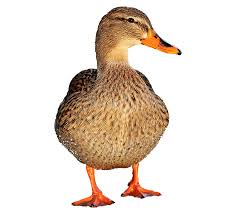

Sorry, I don't know what's in the photo :(


In [141]:
predict('duck.jpg')

In [136]:
# real time ducks vs rabbit recognition
def recognize_in_real_time():
    # desired size
    width = 228
    height = 228
    dim = (width, height)
    
    # stores square coordinates
    y_start = 100
    y_end = 328
    x_start = 100
    x_end = 328


    # capture video (0 - default camera)
    camera = cv2.VideoCapture(0)

    
    opened = True

    while opened:
        # read frame by frame
        ret, frame = camera.read()

        # to grayscale 
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # region of interest 
        region_of_interest_gray = frame_gray[y_start:y_end, x_start:x_end]
        region_of_interest_BGR = frame[y_start:y_end, x_start:x_end]

        # resize
        resized = cv2.resize(region_of_interest_gray, dim)

        # adjust shape to model input shape
        x = img_to_array(resized/255)  # shape (1, 228, 228)
        x = x.reshape((1,) + x.shape)  # kształt (1, 1, 228, 228)

        # predict square
        pred = model.predict(x)

        # color variables
        color_R = (0,255,0)
        color_unsure_R = (0,0,255)
        thickness_R = 2

        # font variables                      
        font = cv2.FONT_HERSHEY_SIMPLEX 
        font_unsure = cv2.FONT_HERSHEY_COMPLEX
        color_F = (0, 255, 0)
        color_unsure_F = (0, 0, 255)
        thickness_F = 2
        f_size = 1
        f_size_unsure = 2

        # prediction threshold
        threshold = 0.9
        
        cv2.rectangle(frame, (x_start, y_start), (x_end, y_end), color_R, thickness_R)

        # Rabbit
        if pred > threshold:
            rabbit_probability = np.round(100*pred[0][0],2)
            
            # Rabbit and probabilty
            cv2.putText(frame, 'RABBIT' + " " + str(rabbit_probability)  + '%', 
                    (x_start-5,y_start-10), font, f_size, color_F, thickness_F, cv2.LINE_AA)
        
        # Duck and probability
        elif pred < 1-threshold:
            duck_probability = np.round(100*(1 - pred[0][0]),2)
            
            cv2.putText(frame, 'DUCK' + " " + str(duck_probability)  + '%', 
                    (x_start-5,y_start-10), font, f_size, color_F, thickness_F, cv2.LINE_AA)
            
        # unsure
        else:
             
 
            # put 'unsure'
            cv2.putText(frame, 'UNSURE', (x_start-5,y_start-10), font_unsure, f_size_unsure, color_unsure_F, thickness_F, cv2.LINE_AA)


        # display frame
        cv2.imshow('Video Recognition', frame)

        # break the loop when press 'q' 
        quit_key = cv2.waitKey(20) & 0xFF 
        if quit_key == ord('q'):
            opened = False

    # turn off camera       
    camera.release()
    cv2.imwrite('last.jpg', frame)       
    cv2.destroyAllWindows()
    display(Img(filename='last.jpg', width=500))

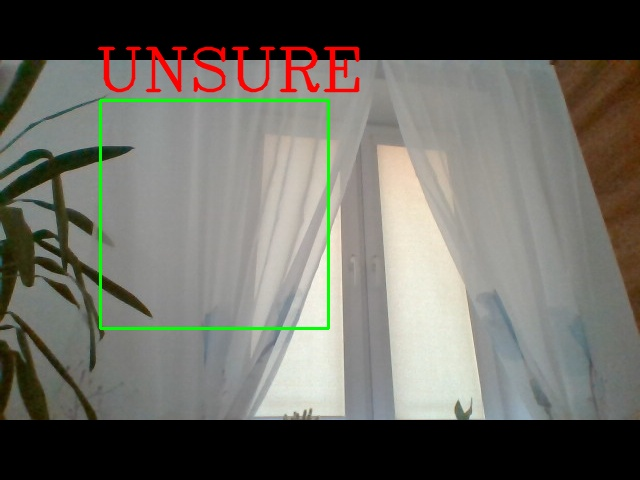

In [137]:
recognize_in_real_time()

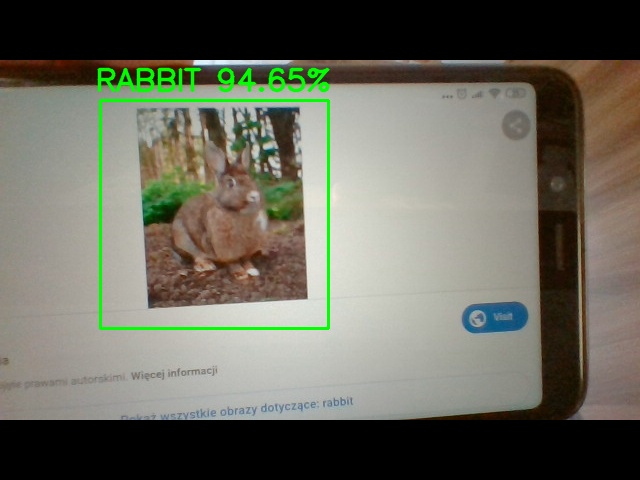

In [146]:
recognize_in_real_time()

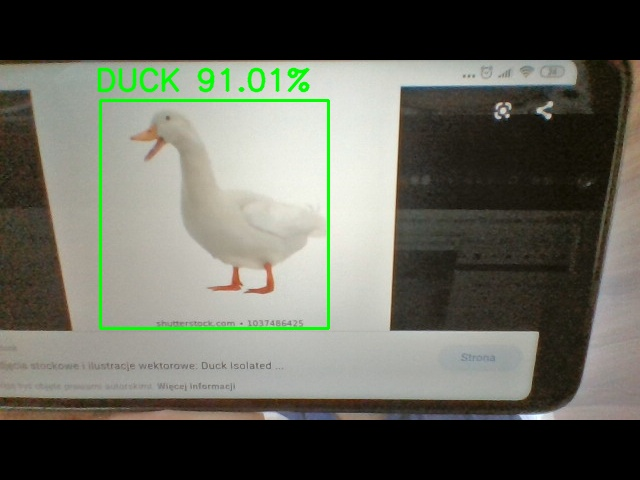

In [149]:
recognize_in_real_time()

# 9. Summary

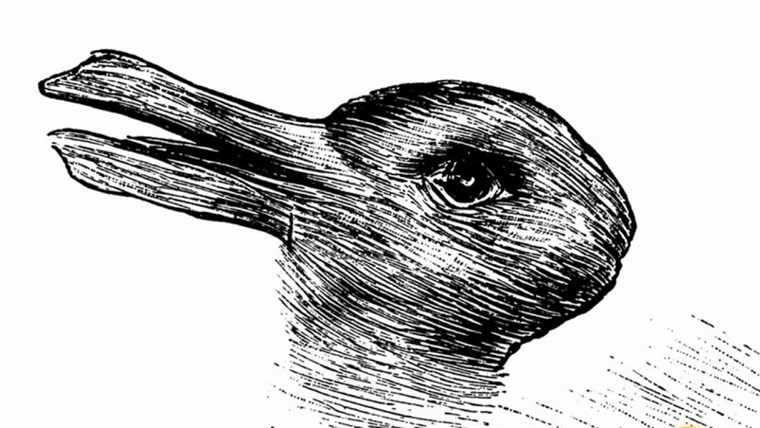

Well... this animal looks like a duck, I'd say for 96.98% ^^


In [128]:
predict('dddd.jpg')

### It seems that AI has already decided ;)

# 10. References
* "Deep learning"; 2016; Ian Goodfellow, Yoshua Bengio, Aaron Courville
* "Python Deep Learning"; 2017; Valentino Zocca, Gianmaro Spacagna, Daniel Slater, Peter Roelants
* Documentation of libraries used in the project